In [1]:
import os
import glob
import functools
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import cv2

import data_io
import u_net

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

tf.__version__

'2.0.0-alpha0'

# Set up

In [3]:
common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67'

img_dir = os.path.join(common_root, 'images')
mask_dir = os.path.join(common_root, 'masks')


batch_size = 5
task = 'cell_seg'

In [4]:
if task == 'nuc_seg':
    x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-2.png'))) # nucleus images
    y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_nucleus.png'))) # nucleus masks     

elif task == 'cell_seg':
    x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-3.png'))) # nucleus images
    y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_cell.png'))) # nucleus masks
    
else:
    raise ValueError('Unknown task.')

# Split into training and validation
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = \
    train_test_split(x_train_fnames, y_train_fnames, test_size=0.2, random_state=43)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 388
Number of validation samples: 98


In [ ]:
idx = np.random.choice(num_train_data)
print(os.path.basename(x_train_fnames[idx]))
print(os.path.basename(y_train_fnames[idx]))

# Test the input pipeline

### Get image and mask from path names

In [ ]:
idx = np.random.choice(num_train_data)
img, mask = data_io._get_image_from_path(x_train_fnames[idx], y_train_fnames[idx])

plt.figure(figsize=(12,16))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])

In [ ]:
print(np.unique(mask))

print(img.shape)
print(img.dtype)
print(mask.shape)
print(img.numpy().max())

### Test the input pipeline

In [ ]:
tmp_ds = data_io.get_dataset(x_train_fnames, y_train_fnames)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(tmp_ds.shuffle(num_train_data).take(3)):
    plt.subplot(3,2,2*i+1)
    plt.imshow(img[0,:,:,0])
    plt.subplot(3,2,2*i+2)
    plt.imshow(mask[0,:,:,0])
plt.show()

# Configure training and validation datasets

In [5]:
# training data
train_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512],
    'to_flip': True
}
tr_preproc_fn = functools.partial(data_io._augment, **train_cfg)

# validation data
val_cfg = {
    'resize': None, 
    'scale': 1/255.,
    'crop_size': [512, 512]
}
val_preproc_fn = functools.partial(data_io._augment, **val_cfg)

train_ds = data_io.get_dataset(x_train_fnames, y_train_fnames, preproc_fn=tr_preproc_fn, 
                       shuffle=True, batch_size=batch_size)
val_ds = data_io.get_dataset(x_val_fnames, y_val_fnames, preproc_fn=val_preproc_fn, 
                     shuffle=False, batch_size=batch_size)

In [ ]:
plt.figure(figsize=(12,16))
for i, (img, mask) in enumerate(train_ds.take(3)):

    plt.subplot(3,3,3*i+1)
    plt.imshow(img[0,:,:,0])
    
    plt.subplot(3,3,3*i+2)
    plt.imshow(mask[0,:,:,0])
    
    plt.subplot(3,3,3*i+3)
    plt.imshow(mask[0,:,:,1])

# Customized loss

In [11]:
import importlib
importlib.reload(u_net)
importlib.reload(data_io)

<module 'data_io' from '/awlab/users/chsu/WorkSpace/tensorflow/segmentation/code/data_io.py'>

In [9]:
val_ds

<BatchDataset shapes: ((None, 512, 512, 1), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

<dtype: 'float32'>
(5, 512, 512)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)


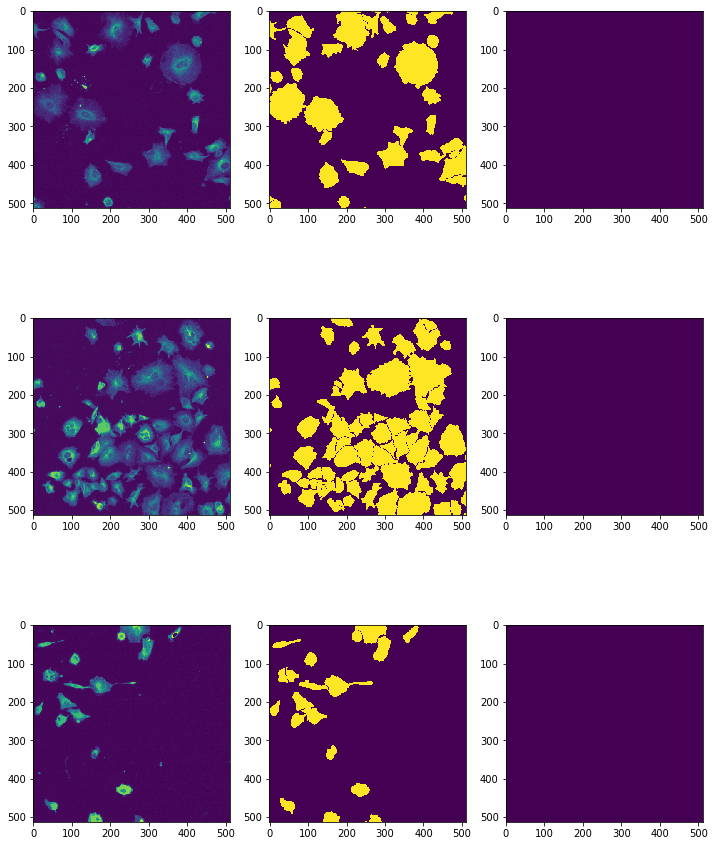

In [12]:
for (img, mask) in val_ds.take(1):
    print(mask.dtype)
    L = u_net.weighted_loss(mask, mask)
    print(L.shape)
    
    plt.figure(figsize=(12,16))
    
    for i, w in enumerate(L):
        if i>2:
            break
            
        plt.subplot(3,3,3*i+1)
        plt.imshow(img[i,:,:,0])

        plt.subplot(3,3,3*i+2)
        plt.imshow(mask[i,:,:,0])

        plt.subplot(3,3,3*i+3)
        plt.imshow(w)
        print((w.numpy().min(), w.numpy().max()))
        


# Build the model

In [14]:
num_filters_list = [32, 64, 128, 256]
model = u_net.Unet(num_filters_list, dynamic=True)
model.compile(optimizer='adam', loss=u_net.weighted_loss, metrics=[u_net.dice_loss])

# plt.figure(figsize=(12,16))
# for i, (img, mask) in enumerate(train_ds.take(1)):
#     y_pred = model(img)
    
#     plt.subplot(1,3,1)
#     plt.imshow(img[0,:,:,0])
#     plt.subplot(1,3,2)
#     plt.imshow(mask[0,:,:,0])
#     plt.subplot(1,3,3)
#     plt.imshow(y_pred[0,:,:,0])
# plt.show()

## Train the model

In [15]:
timestamp = '{}'.format(datetime.datetime.now()).split('.')[0].replace(':','_').replace(' ','_')
root_path = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation'

# model weights
weights_path = os.path.join(root_path, 'models', timestamp, 'weights-{epoch:04d}.ckpt')
weights_dir = os.path.dirname(weights_path)
if not os.path.isdir(weights_dir):
    os.makedirs(weights_dir, exist_ok=True)
cp = tf.keras.callbacks.ModelCheckpoint(filepath=weights_path, monitor='val_dice_loss', 
                                        save_best_only=True, save_weights_only=True, verbose=1)
# tensorboard
log_dir = os.path.join(root_path, 'logs', timestamp)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir, exist_ok=True)
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
history = model.fit(train_ds, epochs=30, 
                    steps_per_epoch=int(np.ceil(num_train_data / batch_size)),
                    validation_data=val_ds,
                    validation_steps=int(np.ceil(num_val_data / batch_size)),
                    callbacks=[cp, tb])

W0412 15:38:29.419918 140040869500672 callbacks.py:1218] TensorBoard Callback will ignore `write_graph=True`when `Model.run_eagerly=True`.`


Epoch 1/30
 6/78 [=>............................] - ETA: 14:47 - loss: 1.0489 - dice_loss: 0.4849

In [ ]:
import importlib
importlib.reload(u_net)

In [ ]:
for (x,y) in train_ds.take(1):
    u_net.bce_dice_loss(y,y)

### Plot training process

In [ ]:
tr_process = pd.DataFrame.from_dict(history.history)
tr_process['epoch'] = np.array(range(1, tr_process.shape[0]+1))

tr_process.plot(x='epoch', y=['loss', 'val_loss'])
tr_process.plot(x='epoch', y=['dice_loss', 'val_dice_loss'])

### Or load the trained weights

In [ ]:
model_dir = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/models/2019-04-05_14_15_41'
latest = tf.train.latest_checkpoint(model_dir)
print(latest)
model.load_weights(latest)

# Visualize performance

In [ ]:
def overlay_mask(img, mask, mask_pred):
    """green: true, red: predicted"""
    I = np.uint8(img.numpy()*255.)
    I = cv2.cvtColor(I,cv2.COLOR_GRAY2RGB)
    
    M = np.uint8(mask.numpy()*255.)
    M_pred = np.uint8((mask_pred.numpy()>0.5) * 255.)
    
    im, contours, _ = cv2.findContours(M.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im_pred, contours_pred, _ = cv2.findContours(M_pred.copy(), 
                                                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    I1 = cv2.drawContours(I.copy(), contours, -1, (0,255,0), 1)
    I2 = cv2.drawContours(I.copy(), contours_pred, -1, (255,0,0), 1)
    I[:,:,1] = I1[:,:,1]
    I[:,:,0] = I2[:,:,0]
    
    return I

In [ ]:
idx_to_plot = np.random.choice(num_val_data, 3)
result_folder = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/results'

if not os.path.isdir(result_folder):
    os.makedirs(result_folder)

# plt.figure(figsize=(12,16))

for i, (img, mask) in enumerate(val_ds):
    if i in idx_to_plot:
        y_pred = model(img)        
        for j in range(4):
            I = overlay_mask(img[j,:,:,0], mask[j,:,:,0], y_pred[j,:,:,0])
            fname = os.path.join(result_folder, '{}_{}.png'.format(i,j))
            cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))
            
#             plt.subplot(2,2,j+1)
#             plt.imshow(I)
            
    if i > max(idx_to_plot):
        break